In [9]:
import os
import numpy as np
import mne

mne.set_log_level("warning")
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from statistics import median
import matplotlib.pyplot as plt

In [36]:
subject_number = 1
current_dir = os.path.dirname(os.path.abspath("."))
load_path = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "Subject" + str(subject_number) + "_epochs.npz",
)

data = np.load(load_path, allow_pickle=True)
block_data = data["block_data"].item()

In [37]:
blocos = block_data.keys()
all_epochs = []
all_labels = []
for bloco in blocos:
    epochs = block_data[bloco]["epochs"]
    labels = block_data[bloco]["labels"]
    # print(f"Bloco: {bloco}, Tamanho: {epochs.shape}") # DEBUG
    all_epochs.append(epochs)
    all_labels.append(labels)

all_epochs = np.concatenate(all_epochs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [38]:
block_data["bloco_ternura1"]["labels"].shape

(108,)

In [39]:
all_epochs.shape
all_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [40]:
def get_custom_groups(labels, n_janelas_emocao=22, n_janelas_neutro=5):
    # Trials por classe separando os neutros que estavam misturados
    trials_angustia = np.where(labels == 2)[0].reshape(16, n_janelas_emocao)
    trials_ternura = np.where(labels == 1)[0].reshape(16, n_janelas_emocao)
    trials_neutro = np.where(labels == 0)[0].reshape(32, n_janelas_neutro)
    indices_neutro_ternura = [
        *range(0, 4),
        *range(8, 12),
        *range(16, 20),
        *range(24, 28),
    ]
    indices_neutro_angustia = [
        *range(4, 8),
        *range(12, 16),
        *range(20, 24),
        *range(28, 32),
    ]
    trials_neutro_ternura = trials_neutro[indices_neutro_ternura]
    trials_neutro_angustia = trials_neutro[indices_neutro_angustia]

    # Criar 16 grupos misturando 1 trial de cada emoção + 2 de neutro
    groups = []
    for i in range(16):
        grupo = np.concatenate(
            [
                trials_neutro_ternura[i],
                trials_ternura[i],
                trials_neutro_angustia[i],
                trials_angustia[i],
            ]
        )
        groups.append(grupo)

    return groups

In [41]:
def runKFold(X, y, pipeline, groups, rep):
    group_ids = np.zeros_like(y)
    for group_idx, grupo in enumerate(groups):
        group_ids[grupo] = group_idx

    # DEBUG: Exibir tamanho dos grupos
    # for i in range(len(groups)):
    #     print(f"Rep: {rep}, Index: {i}, Tamanho dos grupos: {np.bincount(group_ids)}")

    accs = []
    y_test_all = []
    y_pred_all = []
    best_params = None

    # Usar GroupKFold para dividir em treino/teste 25% teste, 75% treino /  4 para teste, 12 para treino
    gkf = GroupKFold(n_splits=8, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=group_ids)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Treinar o modelo
        model = clone(pipeline)

        # Verificar se é GridSearchCV/RandomizedSearchCV
        last_step_name = model.steps[-1][0]
        last_step = model.named_steps[last_step_name]

        if hasattr(last_step, "cv") and isinstance(last_step.cv, GroupKFold):
            # Para GridSearchCV interno, passar os grupos de treino
            train_groups = group_ids[train_idx]
            model.fit(X_train, y_train, **{f"{last_step_name}__groups": train_groups})
            best_params = last_step.best_params_
        else:
            model.fit(X_train, y_train)

        # Fazer previsões
        y_pred = model.predict(X_test)

        # Calcular acurácia
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)

        # Armazenar resultados
        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)

    return accs, np.array(y_test_all), np.array(y_pred_all), best_params

In [42]:
def run_repetitions(X, y, pipeline, groups, n_reps=13):
    accuracy_per_rep = []  # Acurácia média por repetição
    cm_per_rep = []  # Matriz de confusão agregada por repetição
    best_params_per_rep = []  # Melhores parâmetros por repetição

    # 13 repetições
    for rep in range(n_reps):

        accs, y_test_all, y_pred_all, best_params = runKFold(
            X, y, pipeline, groups, rep
        )

        # Armazenar acurácia média da repetição
        accuracy_per_rep.append(np.mean(accs))

        if best_params is not None:
            best_params_per_rep.append(best_params)

        # Calcular matriz de confusão agregada
        cm_rep = confusion_matrix(y_test_all, y_pred_all)
        cm_per_rep.append(cm_rep)

    results = {
        "accuracy_per_rep": accuracy_per_rep,
        "cm_per_rep": cm_per_rep,
    }

    if best_params_per_rep:
        results["best_params"] = best_params_per_rep

    return results

In [ ]:
def get_pipelines(searchType, n_splits):
    lda_pipeline = Pipeline(
        [
            ("csp", CSP(n_components=4, reg="oas", log=True)),
            ("scaler", StandardScaler()),
            ("lda", LinearDiscriminantAnalysis()),
        ]
    )
    if searchType == "grid":
        print("Using GridSearchCV for SVM and Random Forest")
        return (
            lda_pipeline,
            Pipeline(
                [
                    ("csp", CSP(n_components=4, reg="oas", log=True)),
                    ("scaler", StandardScaler()),
                    (
                        "svm",
                        GridSearchCV(
                            SVC(),
                            param_grid={
                                "kernel": ["rbf", "linear"],
                                "C": [0.1, 1, 10],
                                "gamma": [0.001, 0.01, 0.1, "scale"],
                            },
                            cv=GroupKFold(
                                n_splits=n_splits, shuffle=True, random_state=42
                            ),
                        ),
                    ),
                ]
            ),
            Pipeline(
                [
                    ("csp", CSP(n_components=4, reg="oas", log=True)),
                    (
                        "rf",
                        GridSearchCV(
                            RandomForestClassifier(random_state=42),
                            param_grid={
                                "n_estimators": [50, 100, 200],
                                "max_depth": [10, 20, 30],
                            },
                            cv=GroupKFold(
                                n_splits=n_splits, shuffle=True, random_state=42
                            ),
                        ),
                    ),
                ]
            ),
        )
    elif searchType == "random":
        print("Using RandomizedSearchCV for SVM and Random Forest")
        return (
            lda_pipeline,
            Pipeline(
                [
                    ("csp", CSP(n_components=4, reg="oas", log=True)),
                    ("scaler", StandardScaler()),
                    (
                        "svm",
                        RandomizedSearchCV(
                            SVC(),
                            param_distributions={
                                "kernel": ["linear", "rbf"],
                                "C": loguniform(1e-3, 1e3),
                                "gamma": loguniform(1e-4, 1e1),
                            },
                            n_iter=10,
                            cv=GroupKFold(
                                n_splits=n_splits, shuffle=True, random_state=42
                            ),
                            random_state=42,
                        ),
                    ),
                ]
            ),
            Pipeline(
                [
                    ("csp", CSP(n_components=4, reg="oas", log=True)),
                    (
                        "rf",
                        RandomizedSearchCV(
                            RandomForestClassifier(random_state=42),
                            param_distributions={
                                "n_estimators": [100, 200],
                                "max_depth": [None, 10, 20],
                                "min_samples_split": [2, 5, 10],
                                "min_samples_leaf": [1, 2, 5],
                                "max_features": ["sqrt", "log2"],
                            },
                            n_iter=10,
                            cv=GroupKFold(
                                n_splits=n_splits, shuffle=True, random_state=42
                            ),
                            random_state=42,
                        ),
                    ),
                ]
            ),
        )

In [ ]:
X = all_epochs
y = all_labels

lda_pipeline, svm_pipeline, rf_pipeline = get_pipelines("random", n_splits=8)
# lda_pipeline, svm_pipeline, rf_pipeline = get_pipelines("grid")

groups = get_custom_groups(y)

reps = 13

lda_results = run_repetitions(X, y, lda_pipeline, groups, n_reps=reps)
svm_results = run_repetitions(X, y, svm_pipeline, groups, n_reps=reps)
rf_results = run_repetitions(X, y, rf_pipeline, groups, n_reps=reps)

Using RandomizedSearchCV for SVM and Random Forest


In [45]:
save_path = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_ericparams_shuffle_r13k8.npz",
)

np.savez(
    save_path, lda_results=lda_results, svm_results=svm_results, rf_results=rf_results
)

In [1]:
def get_mean_cm(results):
    return np.mean(results.item()["cm_per_rep"], axis=0)

In [2]:
def get_mean_accs(results):
    return {
        "accs": np.mean(results.item()["accuracy_per_rep"]),
        "std": np.std(results.item()["accuracy_per_rep"]),
    }

In [3]:
def get_mean_cms(results):
    return np.mean(results.item()["cm_per_rep"], axis=0)

In [4]:
def display_confusion_matrix(cm, title="Matriz de Confusão", labels=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(title)
    plt.show()

In [5]:
def load_paths(file_paths):
    loaded_results = []
    for file in file_paths:
        loaded = np.load(file, allow_pickle=True)
        loaded_results.append(loaded)

    return loaded_results

In [6]:
def load_and_print_accs_means(file_paths):
    loaded_results = load_paths(file_paths)
    print("Acurácias médias por repetição:")
    for i, results in enumerate(loaded_results):
        lda_accs = get_mean_accs(results["lda_results"])
        svm_accs = get_mean_accs(results["svm_results"])
        rf_accs = get_mean_accs(results["rf_results"])

        print(f"LDA{i+1} Acurácia: {lda_accs['accs']} +- {lda_accs['std']}")
        print(f"SVM{i+1} Acurácia: {svm_accs['accs']} +- {svm_accs['std']}")
        print(f"RF{i+1} Acurácia: {rf_accs['accs']} +- {rf_accs['std']}\n")

In [11]:
def load_and_display_cms_means(file_paths):
    loaded_results = load_paths(file_paths)
    labels = ["Neutro", "Ternura", "Angústia"]
    for i, results in enumerate(loaded_results):
        lda_cm = get_mean_cm(results["lda_results"])
        svm_cm = get_mean_cm(results["svm_results"])
        rf_cm = get_mean_cm(results["rf_results"])

        display_confusion_matrix(
            lda_cm, title=f"LDA{i+1} Matriz de Confusão:", labels=labels
        )
        display_confusion_matrix(
            svm_cm, title=f"SVM{i+1} Matriz de Confusão:", labels=labels
        )
        display_confusion_matrix(
            rf_cm, title=f"RF{i+1} Matriz de Confusão:", labels=labels
        )

Acurácias médias por repetição:
LDA1 Acurácia: 0.782051282051282 +- 0.004833999985932404
SVM1 Acurácia: 0.7833867521367522 +- 0.006731146072448642
RF1 Acurácia: 0.7463497150997151 +- 0.021446760719152892

LDA2 Acurácia: 0.7835648148148149 +- 0.0
SVM2 Acurácia: 0.7858796296296297 +- 1.1102230246251565e-16
RF2 Acurácia: 0.7662037037037039 +- 2.220446049250313e-16

LDA3 Acurácia: 0.7870370370370369 +- 1.1102230246251565e-16
SVM3 Acurácia: 0.7789351851851851 +- 0.0
RF3 Acurácia: 0.7604166666666666 +- 0.0

LDA4 Acurácia: 0.787037037037037 +- 0.0
SVM4 Acurácia: 0.7789351851851851 +- 0.0
RF4 Acurácia: 0.7604166666666666 +- 0.0

LDA5 Acurácia: 0.7835648148148149 +- 0.0
SVM5 Acurácia: 0.7847222222222221 +- 1.1102230246251565e-16
RF5 Acurácia: 0.7534722222222221 +- 1.1102230246251565e-16

LDA6 Acurácia: 0.7835648148148149 +- 0.0
SVM6 Acurácia: 0.7847222222222221 +- 1.1102230246251565e-16
RF6 Acurácia: 0.7534722222222221 +- 1.1102230246251565e-16



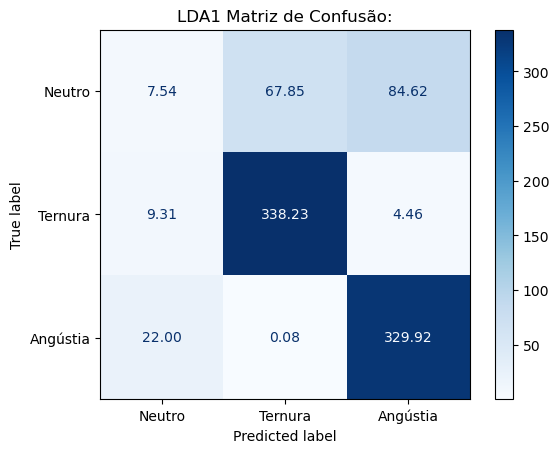

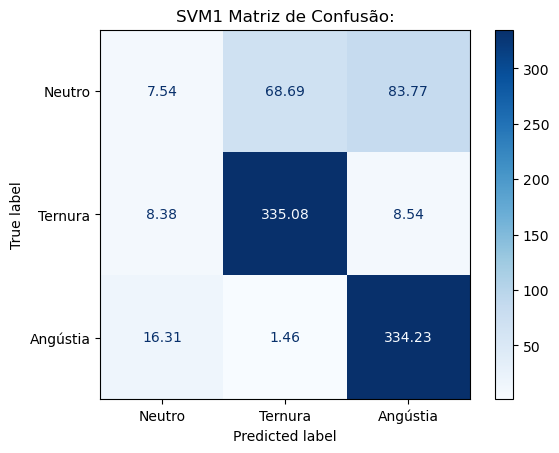

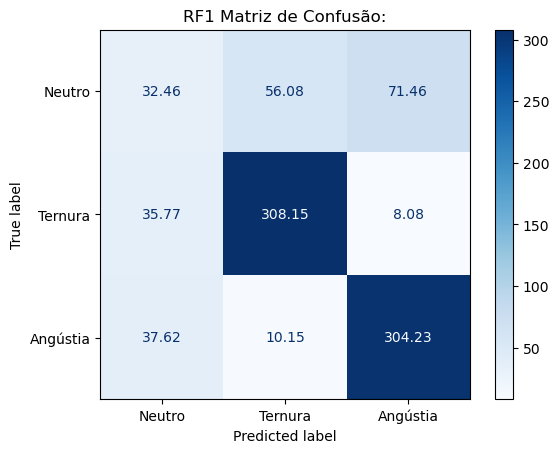

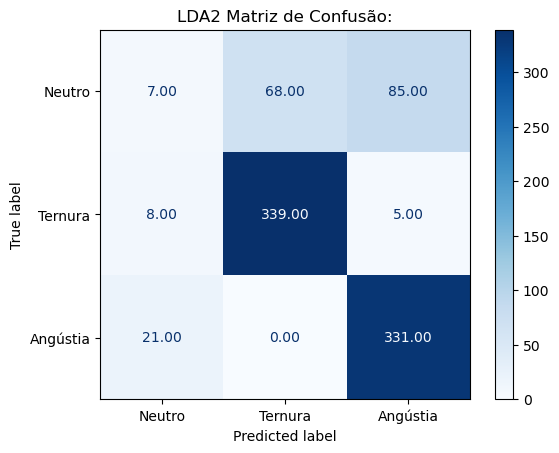

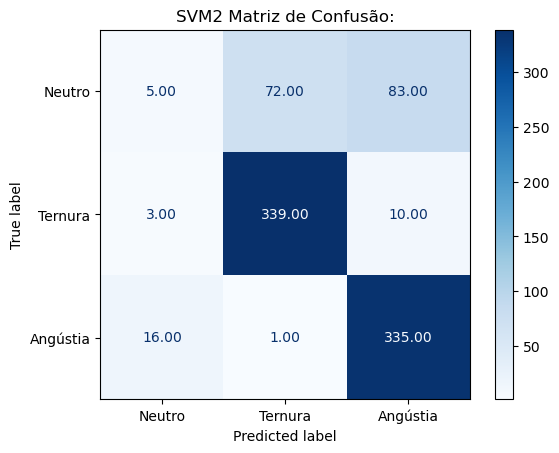

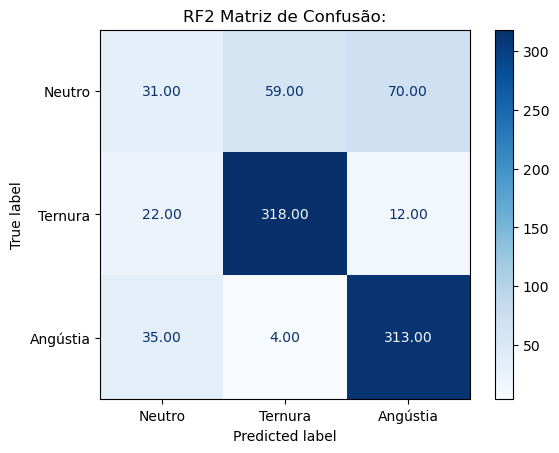

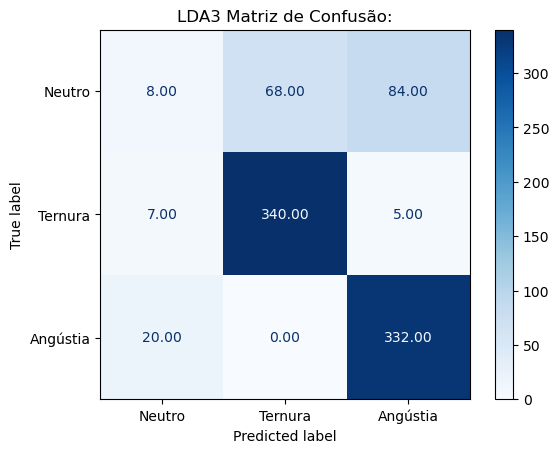

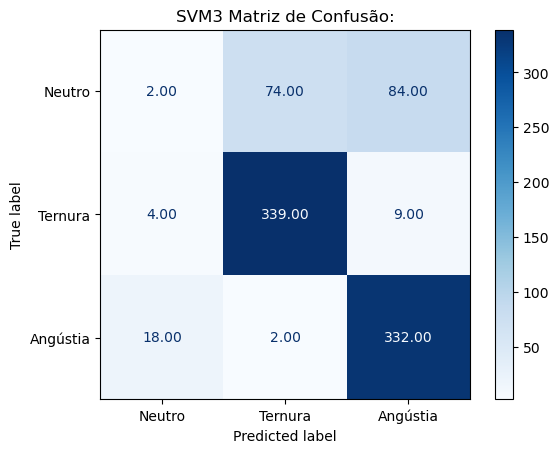

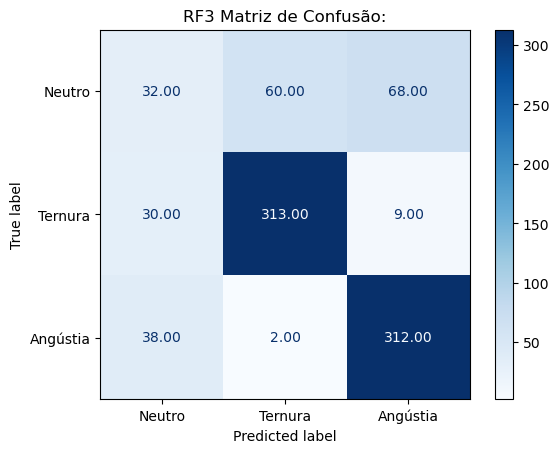

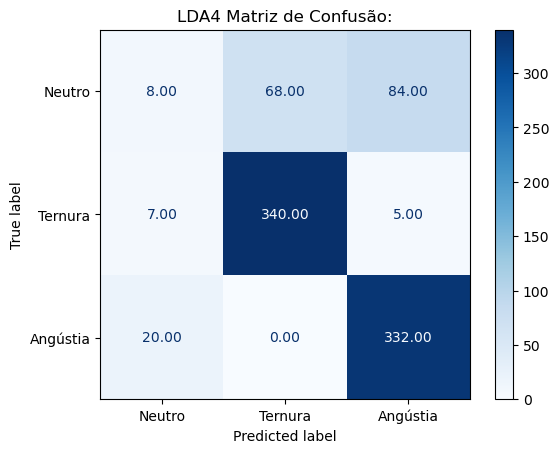

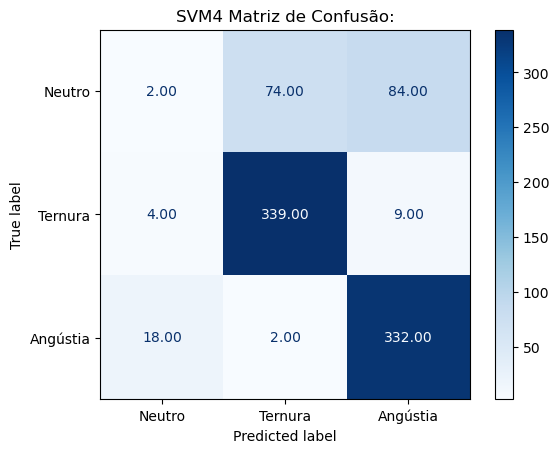

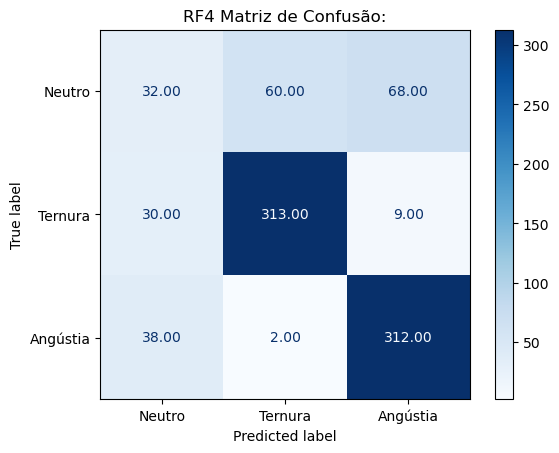

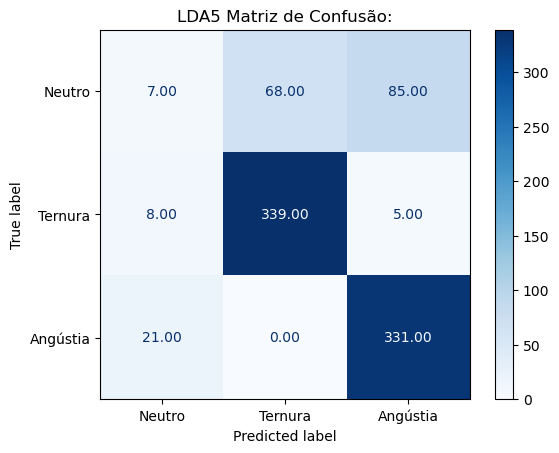

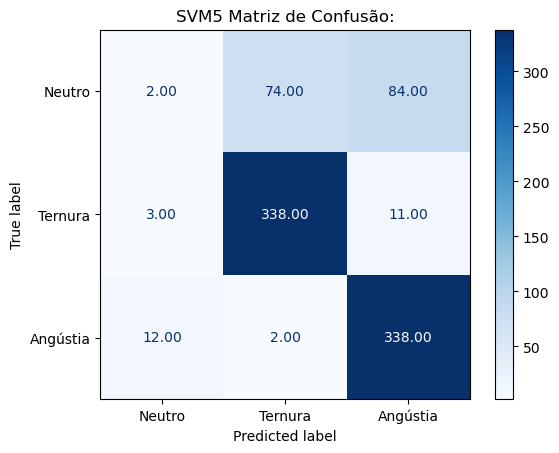

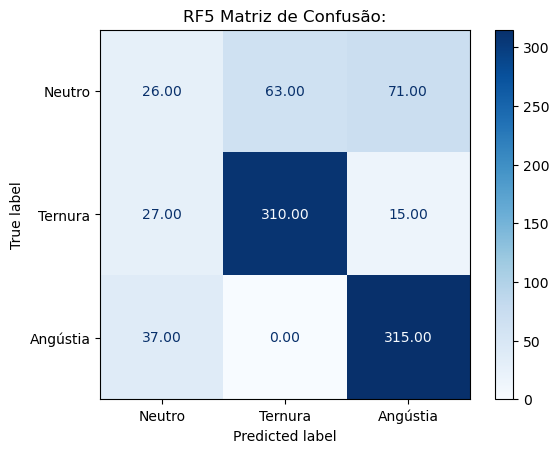

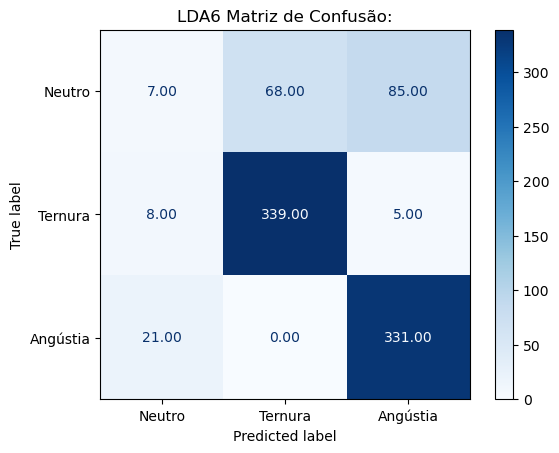

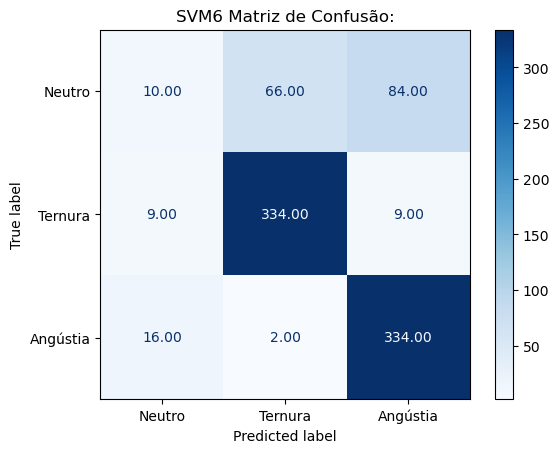

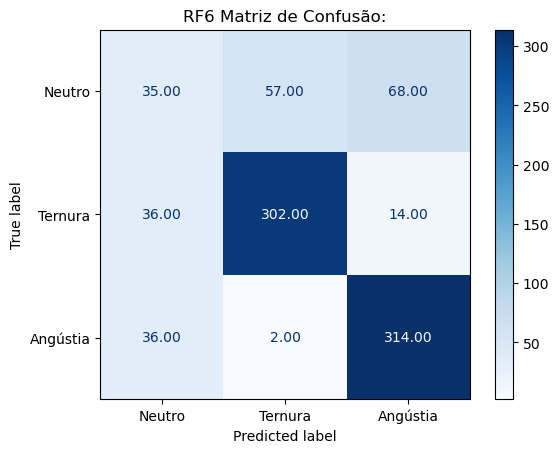

In [12]:
current_dir = os.path.dirname(os.path.abspath("."))
load_path_results1 = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_r13k4.npz",
)
load_path_results2 = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_r13k8.npz",
)
load_path_results3 = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_ericparams_shuffle_r13k4.npz",
)
load_path_results4 = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_ericparams_shuffle_r16k4.npz",
)
load_path_results5 = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_ericparams_shuffle_r13k8.npz",
)
load_path_results6 = os.path.join(
    current_dir,
    "ML",
    "Original",
    "epochs",
    "results_ericparams_shuffle_r13k8_params8.npz",
)

file_paths = [
    load_path_results1,
    load_path_results2,
    load_path_results3,
    load_path_results4,
    load_path_results5,
    load_path_results6,
]

load_and_print_accs_means(file_paths)
load_and_display_cms_means(file_paths)

In [11]:
loaded_results = load_paths(file_paths)
loaded_results[0]["lda_results"].item()["cm_per_rep"]

[array([[  8,  69,  83],
        [  9, 339,   4],
        [ 21,   0, 331]], dtype=int64),
 array([[ 10,  66,  84],
        [ 13, 334,   5],
        [ 23,   0, 329]], dtype=int64),
 array([[  7,  69,  84],
        [ 16, 330,   6],
        [ 21,   0, 331]], dtype=int64),
 array([[  9,  67,  84],
        [ 11, 337,   4],
        [ 26,   0, 326]], dtype=int64),
 array([[  7,  67,  86],
        [  8, 339,   5],
        [ 20,   0, 332]], dtype=int64),
 array([[  8,  68,  84],
        [ 12, 336,   4],
        [ 26,   0, 326]], dtype=int64),
 array([[ 10,  68,  82],
        [  4, 343,   5],
        [ 19,   1, 332]], dtype=int64),
 array([[  5,  68,  87],
        [  6, 342,   4],
        [ 21,   0, 331]], dtype=int64),
 array([[ 11,  64,  85],
        [ 12, 336,   4],
        [ 23,   0, 329]], dtype=int64),
 array([[  5,  69,  86],
        [  9, 339,   4],
        [ 21,   0, 331]], dtype=int64),
 array([[  7,  69,  84],
        [  8, 340,   4],
        [ 21,   0, 331]], dtype=int64),
 array([[ 

In [ ]:
# len(loaded_results[0]["lda_results"].item()["accuracy_per_rep"])

In [ ]:
# loaded_results[0]["svm_results"].item()["best_params"]
# loaded_results[1]["svm_results"].item()["best_params"]

In [ ]:
# lda_mean_accs = np.mean(loaded_results["lda_results"].item()["accuracy_per_rep"])
# lda_mean_cm = get_mean_cm(loaded_results["lda_results"])
# lda_mean_cm

In [ ]:
# np.round(np.mean(loaded_results["lda_results"].item()["cm_per_rep"], axis=0)).astype(
#     int
# )

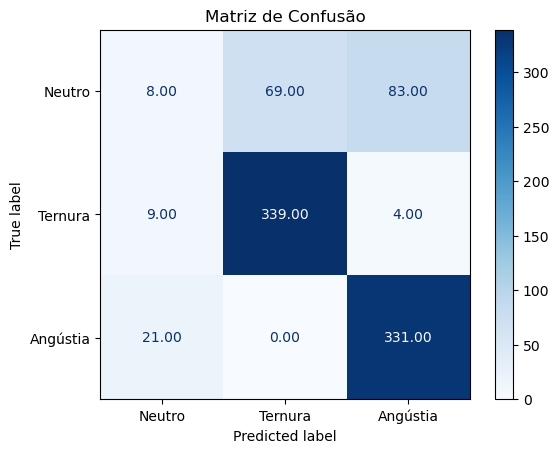

In [14]:
display_confusion_matrix(
    loaded_results[0]["lda_results"].item()["cm_per_rep"][0],
    labels=["Neutro", "Ternura", "Angústia"],
)

In [ ]:
# y = all_labels
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=np.round(
#         np.mean(loaded_results["lda_results"].item()["cm_per_rep"], axis=0)
#     ).astype(int),
#     display_labels=np.unique(y),
# )
# disp.plot(cmap="Blues", values_format="d")  # 'd' para formato inteiro
# plt.title("Matriz de Confusão")
# plt.show()

In [ ]:
# csp = CSP(n_components=4, reg="oas", log=True)

# X_train_csp = csp.fit_transform(X_train, y_train)
# X_test_csp = csp.fit_transform(X_test, y_test)

# scaler = StandardScaler().fit(X_train_csp)
# X_train_features = scaler.transform(X_train_csp)
# X_test_features = scaler.transform(X_test_csp)
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train_features, y_train)

# # y_predict = lda.predict(X_test_features)
# accs.append(lda.score(X_test_features, y_test))

In [ ]:
# groups = get_custom_groups(y)
# for g in groups:
#     print(len(g))
# np.random.shuffle(groups)

# group_ids = np.zeros_like(y)
# for group_idx, grupo in enumerate(groups):
#     group_ids[grupo] = group_idx

# for i in range(len(groups)):
#     print(f"Index: {i}, Value: {np.where(group_ids == i)[0].shape}")